# Digit Recognizer

## 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
np.random.seed(2)

sns.set(style='white', context='notebook', palette='deep')

## 2. Data preparation

### 2.1 Load data

In [3]:
# Load the data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

In [4]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

# Free some space
del df_train

C:\Users\Benjamin\anaconda3\envs\dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

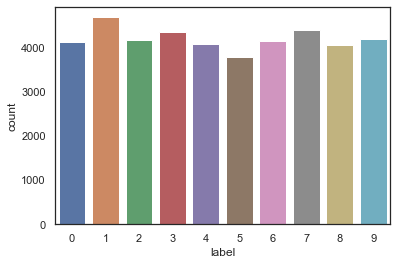

In [6]:
g = sns.countplot(y_train)
y_train.value_counts()

### 2.2 Check the null and missing values

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
df_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [9]:
X_train.pixel524.describe()

count    42000.000000
mean        57.809762
std         95.899298
min          0.000000
25%          0.000000
50%          0.000000
75%         94.000000
max        255.000000
Name: pixel524, dtype: float64

In [10]:
# Normalize the data
X_train = X_train / 255.0
df_test = df_test / 255.0

In [11]:
X_train.pixel524.describe()

count    42000.000000
mean         0.226705
std          0.376076
min          0.000000
25%          0.000000
50%          0.000000
75%          0.368627
max          1.000000
Name: pixel524, dtype: float64

### 2.4 Reshape

In [12]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
df_test = df_test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [13]:
X_train.shape

(42000, 28, 28, 1)

### 2.5 Label encoding

In [14]:
y_train = to_categorical(y_train, num_classes=10)

### 2.6 Split training and validation set

In [15]:
# Set the random seed
random_seed = 2

In [16]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

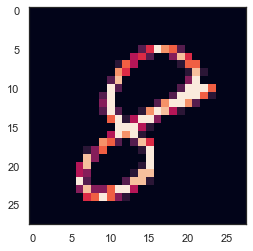

In [17]:
# Visualize an image
g = plt.imshow(X_train[0][:,:,0])

## 3. CNN

### 3.1 Define the model

We use the Keras sequential API to define a CNN.



In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

### 3.2 Define optimizer and loss function

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
# Compile the model
model.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [22]:
epochs = 36
batch_size = 86

In [23]:
# Run
history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, 
    validation_data=(X_val, y_val), verbose=2
)

Epoch 1/36
440/440 - 93s - loss: 0.2487 - accuracy: 0.9215 - val_loss: 0.0693 - val_accuracy: 0.9786
Epoch 2/36
440/440 - 91s - loss: 0.0724 - accuracy: 0.9779 - val_loss: 0.0492 - val_accuracy: 0.9871
Epoch 3/36
440/440 - 99s - loss: 0.0521 - accuracy: 0.9848 - val_loss: 0.0452 - val_accuracy: 0.9886
Epoch 4/36
440/440 - 103s - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.0420 - val_accuracy: 0.9881
Epoch 5/36
440/440 - 104s - loss: 0.0397 - accuracy: 0.9879 - val_loss: 0.0344 - val_accuracy: 0.9902
Epoch 6/36
440/440 - 103s - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.0507 - val_accuracy: 0.9902
Epoch 7/36
440/440 - 103s - loss: 0.0346 - accuracy: 0.9895 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 8/36
440/440 - 105s - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0299 - val_accuracy: 0.9931
Epoch 9/36
440/440 - 108s - loss: 0.0316 - accuracy: 0.9909 - val_loss: 0.0341 - val_accuracy: 0.9905
Epoch 10/36
440/440 - 103s - loss: 0.0294 - accuracy: 0.9915 - val_loss: 0.0474 - val

### 3.3 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

* Without data augmentation i obtained an accuracy of 98.114%
* With data augmentation i achieved 99.67% of accuracy

In [25]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False # randomly flip images
)


datagen.fit(X_train)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset 

In [27]:
# Fit the model
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, validation_data=(X_val, y_val),
    verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/36
439/439 - 100s - loss: 0.2169 - accuracy: 0.9471 - val_loss: 0.0613 - val_accuracy: 0.9905
Epoch 2/36
439/439 - 103s - loss: 0.1538 - accuracy: 0.9618 - val_loss: 0.0354 - val_accuracy: 0.9910
Epoch 3/36
439/439 - 112s - loss: 0.1329 - accuracy: 0.9668 - val_loss: 0.0433 - val_accuracy: 0.9919
Epoch 4/36
439/439 - 113s - loss: 0.1236 - accuracy: 0.9678 - val_loss: 0.0637 - val_accuracy: 0.9886
Epoch 5/36
439/439 - 111s - loss: 0.1192 - accuracy: 0.9700 - val_loss: 0.0525 - val_accuracy: 0.9883
Epoch 6/36
439/439 - 110s - loss: 0.1199 - accuracy: 0.9698 - val_loss: 0.0538 - val_accuracy: 0.9898
Epoch 7/36
439/439 - 104s - loss: 0.1228 - accuracy: 0.9696 - val_loss: 0.0322 - val_accuracy: 0.9917
Epoch 8/36
439/439 - 106s - loss: 0.1175 - accuracy: 0.9710 - val_loss: 0.0705 - val_accuracy: 0.9893
Epoch 9/36
439/439 - 103s - loss: 0.1120 - accuracy: 0.9724 - val_loss: 0.0528 - val_accuracy: 0.9879
Epoch 

## 4. Evaluate the model

### 4.1 Training and validation curves

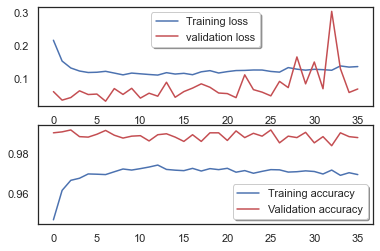

In [30]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)